# Self-Exciting process (Hawkes process)

For a review of self-exciting point processes and more please see https://arxiv.org/pdf/1507.02822.pdf.

Hear a Poisson point process's intensity, $\lambda(t)$, is conditionally dependent on past events.

Let the intensity be given by a constant background plus an exponential term:

$$\lambda(t) = \mu + \sum_{t_i < t}  \phi(t-t_i)$$

The average number of _daughters_ from an event is $\int_0^\infty \phi(t) \mathrm{d} t$ and is called the branching ratio. If the branching ratio is > 1 then there is non-zero probability of having infinite events spawned from a single event.

We'll let $\phi(t) = \alpha e^{-\beta t}$, where $\int_0^\infty \phi(t) \mathrm{d} t = \alpha/\beta \triangleq B$.

In [1]:
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp, vmap

from jaxns import resample

tfpd = tfp.distributions

INFO[2023-12-11 13:47:38,728]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:47:38,729]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-11 13:47:38,730]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-11 13:47:38,730]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Generate data

num_samples = 10

event_times = jnp.concatenate([jnp.linspace(0., 1., num_samples) ** 2,
                               2. + jnp.linspace(0., 1., num_samples) ** 2])

In [3]:
from jaxns import Prior, Model

# Build model
B = 2.0


def lam_t(mu, alpha, beta, t):
    dt = t[:, None] - event_times[None, :]
    # a-a, a-b
    phi = alpha * jnp.exp(-beta * jnp.where(dt > 0, dt, 0)) * jnp.where(dt > 0, 1, 0)
    lam = mu + jnp.sum(phi, axis=1)
    return lam


def log_likelihood(mu, alpha, beta):
    """
    Poisson likelihood.
    """
    lam = lam_t(mu, alpha, beta, event_times)
    Lam = mu + B * event_times.size
    return jnp.sum(jnp.log(lam)) - Lam


def prior_model():
    mu = yield Prior(tfpd.HalfCauchy(loc=0, scale=1.), name='mu')
    beta = yield Prior(tfpd.HalfNormal(num_samples), name='beta')
    alpha = yield Prior(tfpd.Uniform(0., B * beta), name='alpha')
    return mu, alpha, beta


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)

INFO[2023-12-11 13:47:39,450]: Sanity check...
INFO[2023-12-11 13:47:39,857]: Sanity check passed


In [4]:
import jax
from jaxns import NestedSampler

ns = NestedSampler(model=model, max_samples=1e6)

termination_reason, state = jax.jit(ns)(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)

/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "


--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 39565
samples: 2688
phantom samples: 1152.0
likelihood evals / sample: 14.7
phantom fraction (%): 42.9%
--------
logZ=5.36 +- 0.19
H=13000.0
ESS=440.94940185546875
--------
alpha: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
alpha: 11.9 +- 5.8 | 5.7 / 11.2 / 19.8 | 9.1 | 11.6
--------
beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
beta: 6.6 +- 3.1 | 3.1 / 6.2 / 10.4 | 4.5 | 5.8
--------
mu: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
mu: 8.8 +- 4.1 | 3.6 / 8.5 / 13.9 | 5.8 | 10.0
--------


WARNING[2023-12-11 13:47:50,703]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


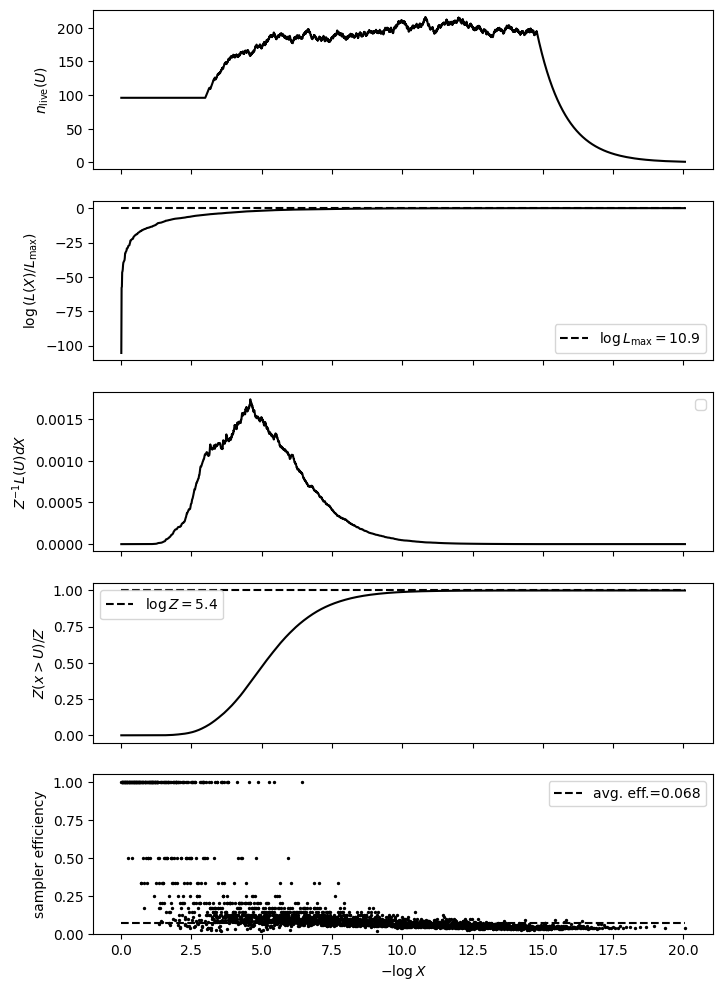

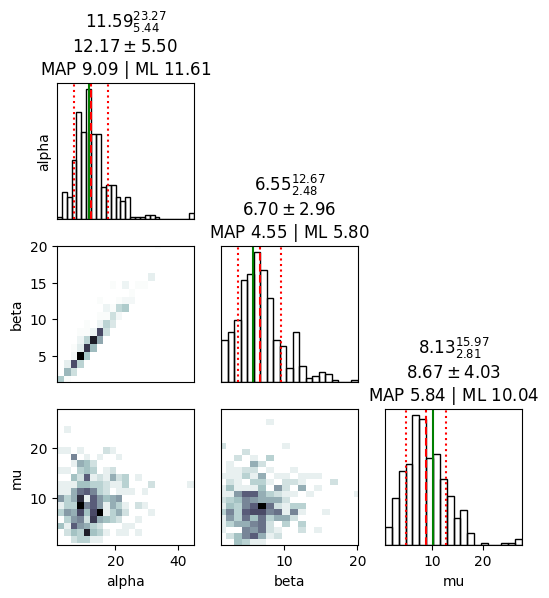

In [5]:
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)

In [6]:
samples = resample(random.PRNGKey(42), results.samples, results.log_dp_mean, replace=True)
pred_times = jnp.linspace(0., 4., 100)
pred_lam = vmap(lambda mu, alpha, beta: lam_t(mu, alpha, beta, pred_times))(**samples)

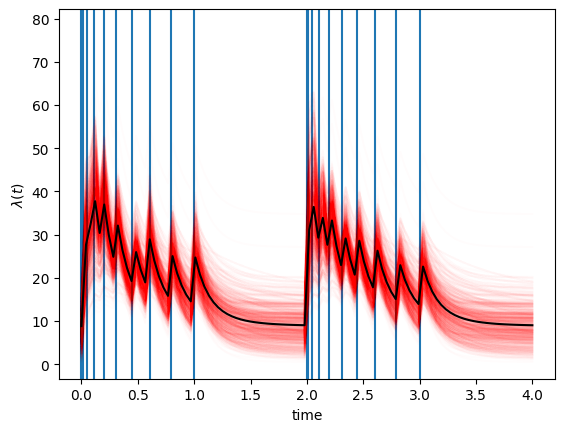

In [7]:
[plt.axvline(e) for e in event_times]
plt.plot(pred_times, pred_lam.T, c='red', alpha=0.01)
plt.plot(pred_times, pred_lam.mean(0), c='black')
plt.xlabel('time')
plt.ylabel(r'$\lambda(t)$')
plt.show()

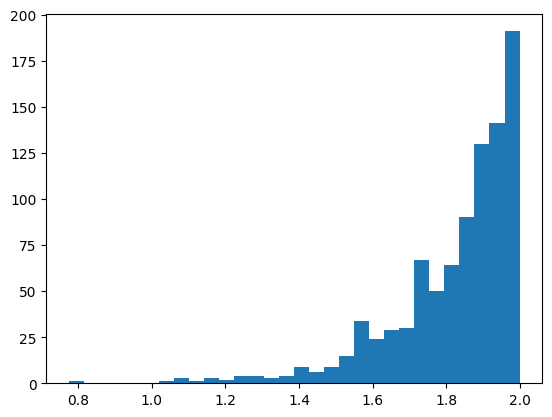

In [8]:
B = samples['alpha'] / samples['beta']
plt.hist(B, bins='auto')
plt.show()